# Week 2 - **Finance**


# *Import Libraries and Data*

In [0]:
# import basic libraries.

import numpy as np  # numeric
import pandas as pd # dataframes
%matplotlib inline
import matplotlib.pyplot as plot #plot data
from matplotlib import style
import seaborn as sns # another library to plot data
import datetime as date
import math as math
from sklearn import preprocessing



In [0]:
# allow data from yahoo API

!pip install yfinance --upgrade --no-cache-dir

In [0]:
# import data from yahoo finance
from pandas_datareader import data as preader
import fix_yahoo_finance as yahoo


In [0]:
# Allow to connect the GoogleDrive to this notebook
from google.colab import drive
drive.mount('drive',force_remount=True)


In [6]:
# start and end date analysis
start_date = date.date(2015,1,1)
end_date = date.date(2019,1,1)

yahoo.pdr_override()
df_yahoo = preader.get_data_yahoo('JPM', start_date, end_date).reset_index()
df_yahoo.to_csv('JPM.csv', index=False) 
df_yahoo.describe()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
count,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1.006000e+03
mean,83.024453,83.696909,82.324413,83.009861,77.874333,1.551454e+07
std,20.403937,20.568895,20.223518,20.359879,21.343376,6.035127e+06
min,53.900002,53.910000,50.070000,53.070000,48.080933,3.680000e+06
25%,63.939999,64.357498,63.572501,64.040001,58.261119,1.171372e+07
50%,84.220001,85.255001,83.799999,84.430001,79.031639,1.405950e+07
75%,104.097498,105.165001,102.910004,103.727502,100.110365,1.760562e+07
max,119.129997,119.330002,118.080002,118.769997,115.153419,5.619230e+07


In [7]:
df_yahoo.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
996,2018-12-17,99.769997,100.559998,98.440002,99.010002,96.781433,25113500
997,2018-12-18,99.419998,100.889999,98.120003,98.540001,96.322014,20837200
998,2018-12-19,98.410004,100.580002,96.599998,97.290001,95.100151,28767900
999,2018-12-20,96.610001,98.279999,95.690002,96.449997,94.279053,31825200
1000,2018-12-21,96.680000,98.430000,93.690002,94.169998,92.050377,41313900
1001,2018-12-24,92.889999,94.220001,92.139999,92.139999,90.066071,17009300
1002,2018-12-26,92.690002,95.959999,91.110001,95.959999,93.800095,22542900
1003,2018-12-27,94.820000,97.150002,93.550003,97.040001,94.855774,20304700
1004,2018-12-28,97.949997,98.320000,96.440002,96.830002,94.650513,17963300
1005,2018-12-31,97.589996,98.809998,96.769997,97.620003,95.422729,13237200


***How the data lookslike***


In [0]:

# days average: smooth the data creating a average price in n days (example: 50)
df_reduce_dim = df_yahoo["Adj Close"]

# Drop the missing values:
df_reduce_dim.dropna()


df_avg = df_reduce_dim.rolling(window=50).mean()


In [9]:
df_reduce_dim.describe()

count    1006.000000
mean       77.874333
std        21.343376
min        48.080933
25%        58.261119
50%        79.031639
75%       100.110365
max       115.153419
Name: Adj Close, dtype: float64

In [10]:
df_avg.describe()

count    957.000000
mean      77.965580
std       20.949489
min       52.049950
25%       57.966782
50%       78.966143
75%      100.132331
max      111.909319
Name: Adj Close, dtype: float64

In [11]:
df_avg.tail(5)

1001    103.674121
1002    103.459269
1003    103.277455
1004    103.046963
1005    102.808259
Name: Adj Close, dtype: float64

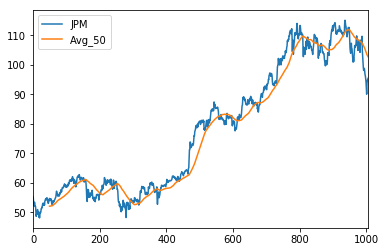

In [12]:
# a view from the data and his average
df_reduce_dim.plot(label='JPM')
df_avg.plot(label='Avg_50')
plot.legend()

# *Data Pre-Processing*

In [13]:

# reduce dimension to:
df_model = df_yahoo.loc[:,["Adj Close","Volume"]]

# add some features:
df_model["hl_p"] = (df_yahoo["High"] - df_yahoo["Low"]) / df_yahoo["Close"] * 100.0 # high and low in same the day.
df_model["co_p"] = (df_yahoo["Close"] - df_yahoo["Open"]) / df_yahoo["Open"] * 100.0 # open and close in the same day.
df_model.head()


,Adj Close,Volume,hl_p,co_p
0,55.251518,12600000,1.424226,0.498556
1,53.536236,20100600,3.385630,-2.433132
2,52.148098,29074100,4.069179,-2.737465
3,52.227676,23843200,2.065348,-1.369175
4,53.394768,16971100,1.539992,0.700347


In [0]:
# forecast the 3 % of the total days
forecast_3porc = int(math.ceil(0.03 * len(df_model)))

In [0]:
# the column to forecast:
forecast_column = 'Adj Close'
df_model['label'] = df_model[forecast_column].shift(-forecast_3porc) # 

# separate the data to preprocessing
X = np.array(df_model.drop(['label'],1))

In [26]:

# preprocessing scale: Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_3porc:]
X = X[:-forecast_3porc]

# Separate label and identify it as y
y = np.array(df_model['label'])
y = y[:-forecast_3porc]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)


Dimension of X (975, 4)
Dimension of y (975,)


**The predict Model**

In [0]:

# Basic libraries
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
# splitting the train and test sets
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
from sklearn import metrics

In [0]:
# function to plot the results:
def fun_plot(model_prediction):
  plot.scatter(model_prediction, y_test, color="green")
  plot.plot(y_test, y_test, color='blue', linewidth=3)

In [0]:
# funtion to calculate the performance metrics:
def fun_metrics(model_prediction):
  #Function returns standard performance metrics
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, model_prediction).round(4))  
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, model_prediction).round(4))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, model_prediction)).round(4))


Linear Regression
Mean Absolute Error: 3.5595
Mean Squared Error: 22.1793
Root Mean Squared Error: 4.7095
Confidence : 0.9496684450350156


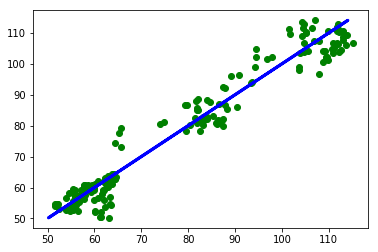

In [47]:
# Linear Regression:

LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
Y_LR_predict = LR_model.predict(X_test)
print("Linear Regression")
fun_plot(Y_LR_predict)
fun_metrics(Y_LR_predict)
print('Confidence :', LR_model.score(X_test, y_test))
  
  

Quadratic Regression Ridge
Mean Absolute Error: 3.6715
Mean Squared Error: 21.9635
Root Mean Squared Error: 4.6865
Confidence : 0.9501582586018985


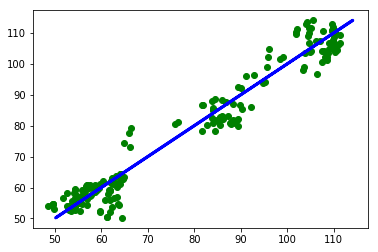

In [48]:
# Quadratic Regression Ridge

QR_model = make_pipeline(PolynomialFeatures(2), Ridge())
QR_model.fit(X_train, y_train)
Y_QR_predict = QR_model.predict(X_test)
print("Quadratic Regression Ridge")
fun_plot(Y_QR_predict)
fun_metrics(Y_QR_predict)
print('Confidence :', QR_model.score(X_test, y_test))
  

K Nearest Neighbor
Mean Absolute Error: 3.8216
Mean Squared Error: 31.2229
Root Mean Squared Error: 5.5877
Confidence : 0.9291458399350466


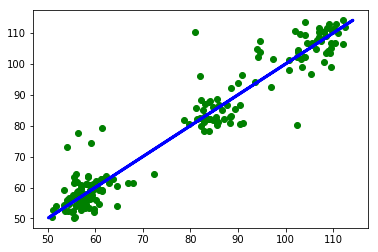

In [49]:
# KNN Regression
KNN_model = KNeighborsRegressor(n_neighbors=2)
KNN_model.fit(X_train, y_train)
Y_KNN_predict = KNN_model.predict(X_test)
print("K Nearest Neighbor")
fun_plot(Y_KNN_predict)
fun_metrics(Y_KNN_predict)
print('Confidence :', KNN_model.score(X_test, y_test))
